# Optimization of E. coli growth parameters for NUFEB
This notebook utilizes hyperparameter optimization to fit simulated E. coli growth curves to experimental data. Under the hood, we use scikit-optimize to perform a Bayesian optimization.

In [8]:
#Imports
import os
from random import uniform
import subprocess
from pathlib import Path
from nufeb_tools import utils,plot
import pandas as pd
import numpy as np

from skopt import gp_minimize
from skopt.plots import plot_convergence, plot_objective
import matplotlib.pyplot as plt
from scipy import interpolate
from sklearn.metrics import r2_score

# Optimization function
## Parameters to optimize:
### $\mu_{max}$ (Monod-based growth rate, $s^{-1}$)
### $\rho$ (Cell density, $\frac{kg}{m^3}$)
### $k_{sucrose}$ (Sucrose uptake half-maximum, $\frac{kg}{m^3}$)
### m (Cellular maintenance cost, $s^{-1}$)

In [3]:
def func(x):

    mu = x[0]
    rho = x[1]
    ksuc = x[2]
    maint = x[3]
    exp_x = np.array([ 0. ,  6.5, 10. , 12. , 14.5, 16.5, 18.5, 22.5, 26.5, 33. , 48. ,58. , 77. , 98. ])
    exp_y = np.array([0.003, 0.025, 0.11 , 0.245, 0.388, 0.44 , 0.504, 0.64 , 0.725, 0.788, 0.79 , 0.8  , 0.825, 0.83 ])

    #Clean old simulations
    os.system('nufeb-clean')

    #Run simulation
    os.chdir('/lustre/or-scratch/cades-cnms/12x')
    text = f'nufeb-seed --cells 0,100 --grid 10 --t 17300 --suc 58.4 --muecw {mu}  --rhoecw {rho} --ksuc {ksuc} --maintecw {maint}'
    os.system(text)
    run_nufeb = subprocess.run('/home/12x/NUFEB/optim.sh', stdout=subprocess.DEVNULL)

    #Extract output
    BASE_DIR = Path(f'runs/')
    folders = [path for path in BASE_DIR.iterdir() if path.is_dir()]
    data = [utils.get_data(directory=str(x)) for x in folders]
    Volume = 1e-4*1e-4*1e-5 #m^3
    CellNum2OD = Volume/1e-9
    df = pd.concat([data.ntypes.ecw/CellNum2OD,data.ntypes.step/60/60*data.timestep],axis=1)
    df.columns=['OD600','Hours']


    #Compare output with experimental data
    exp = interpolate.interp1d(exp_x,exp_y)
    sim = interpolate.interp1d(df.Hours.to_numpy(),df.OD600.to_numpy())
    x_range = np.arange(0,48,.1)
    residual = abs(r2_score(exp(x_range),sim(x_range))-1)



    print(residual)
    return residual
    #Optimize
"""    file_pi = open('results.obj', 'w') 
    pickle.dump(res, file_pi) """

' def optimize():\n    \n\n    res = gp_minimize(func,                  # the function to minimize\n                    ,      # the bounds on each dimension of x\n                    acq_func="EI",      # the acquisition function\n                    n_calls=5,         # the number of evaluations of f\n                    n_random_starts=5,  # the number of random initialization points\n                    random_state=1234)\n    print(res)\n    file_pi = open(\'results.obj\', \'w\') \n    pickle.dump(res, file_pi) '

In [13]:
mu_min = float('5.5e-5')
mu_max = float('1.1e-4')
rho_min = 185
rho_max = 307
k_suc_min = float('1e-1')
k_suc_max = float('1e1')
m_min = float('1e-8')
m_max = float('1e-6')
bounds = [(mu_min,mu_max),(rho_min,rho_max),(k_suc_min,k_suc_max),(m_min,m_max)]
n_calls = 20
gp_res = gp_minimize(func, bounds, n_calls=n_calls,n_initial_points =5, random_state=1234,verbose=True)

2.317309270161661
2.2206752633527094
2.430719688113327
2.472729477197139
2.6219607487188834
2.1671035073063933
2.391772955333262
2.839568393369969
5.126926591324398
2.0139070344584318
3.8753829367541615
1.7972858620505425
2.205738167207465
1.8071007947859035
2.151009899160437
3.192803245778821
2.42975878020256
2.4043597258086993
2.8493773730949465
3.2597101291439077
3.3180162870117247
2.196162130687999
2.865814803073399
2.4858526957669542
2.973365991102276
2.467839127194506
2.1638248874214394
2.9470277079224427
3.5593135420347766
1.9779996541201197
2.0951163031157733
2.0896343250309015
2.9352701442098006
2.1748481413815854
1.7311334279101631
1.6606297902248959
1.5865387693609816
1.880618113274391
1.8624434087080326
1.6363951653500672
1.563379718640439
1.599849126025258
1.5492946760495006
1.6496827970474173
1.5990054110893732
1.544325723177976
1.596849708786833
1.6763637906763793
1.6557587038827324
1.6402969346768252
1.7439179232481479
1.634209325287027
1.5637759775215843
1.712814937559

<AxesSubplot:title={'center':'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

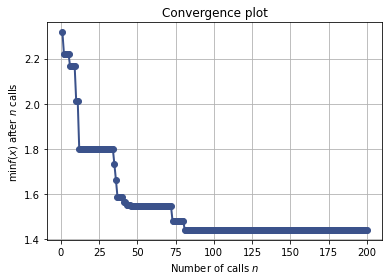

In [14]:
plot_convergence(gp_res)

array([[<AxesSubplot:xlabel='$X_{0}$', ylabel='Partial dependence'>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:ylabel='$X_{1}$'>,
        <AxesSubplot:xlabel='$X_{1}$', ylabel='Partial dependence'>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:ylabel='$X_{2}$'>, <AxesSubplot:>,
        <AxesSubplot:xlabel='$X_{2}$', ylabel='Partial dependence'>,
        <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:ylabel='$X_{3}$'>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:xlabel='$X_{3}$', ylabel='Partial dependence'>,
        <AxesSubplot:>],
       [<AxesSubplot:xlabel='$X_{0}$', ylabel='$X_{4}$'>,
        <AxesSubplot:xlabel='$X_{1}$'>, <AxesSubplot:xlabel='$X_{2}$'>,
        <AxesSubplot:xlabel='$X_{3}$'>,
        <AxesSubplot:xlabel='$X_{4}$', ylabel='Partial dependence'>]],
      dtype=object)

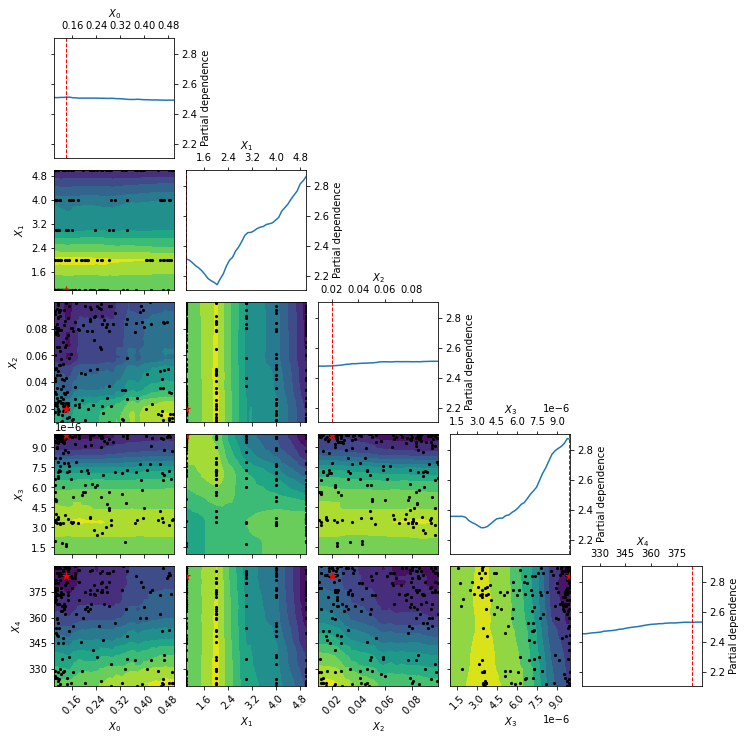

In [15]:
plot_objective(gp_res)

In [10]:
print(gp_res)

Help on OptimizeResult in module scipy.optimize.optimize object:

class OptimizeResult(builtins.dict)
 |  Represents the optimization result.
 |  
 |  Attributes
 |  ----------
 |  x : ndarray
 |      The solution of the optimization.
 |  success : bool
 |      Whether or not the optimizer exited successfully.
 |  status : int
 |      Termination status of the optimizer. Its value depends on the
 |      underlying solver. Refer to `message` for details.
 |  message : str
 |      Description of the cause of the termination.
 |  fun, jac, hess: ndarray
 |      Values of objective function, its Jacobian and its Hessian (if
 |      available). The Hessians may be approximations, see the documentation
 |      of the function in question.
 |  hess_inv : object
 |      Inverse of the objective function's Hessian; may be an approximation.
 |      Not available for all solvers. The type of this attribute may be
 |      either np.ndarray or scipy.sparse.linalg.LinearOperator.
 |  nfev, njev, nhe

In [12]:
gp_res.values()

dict_values([[0.2923783930150564, 2, 0.014081961016642342, 7.3999160434903736e-06, 387], 1.6165910383971773, array([2.69828674, 2.75110595, 3.64434888, 2.35795337, 3.85694215,
       1.91683077, 1.90659662, 1.76570587, 2.62620967, 1.7857185 ,
       1.89538167, 2.93922636, 1.91559317, 1.91269328, 2.08153859,
       2.09538412, 1.94744157, 2.65514355, 1.85494365, 1.99631074,
       1.97312984, 1.75764369, 2.12746415, 2.76906567, 1.72999238,
       1.74942673, 1.65912385, 1.84359766, 1.62940599, 2.16853581,
       1.64919981, 1.72164713, 1.81165462, 1.7871824 , 1.72377031,
       1.74469676, 1.62640609, 1.61659104, 1.71411201, 1.69218925,
       1.72413894, 1.80567778, 2.1872113 , 1.83667889, 2.04543235,
       1.63060075, 2.65278178, 1.77910583, 1.80173545, 1.78479092]), [[0.35367110463511375, 5, 0.07612903253615567, 5.0982502308523464e-06, 386], [0.1332038056196606, 1, 0.010126855472728152, 3.6610951844776638e-06, 359], [0.2903703368891183, 5, 0.02117667915860789, 7.419671562254157e-06

In [ ]:
gp_res.x